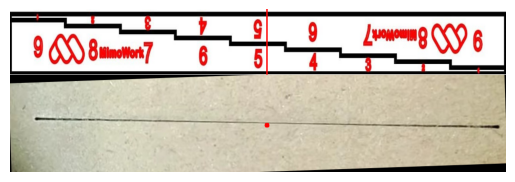

Value marked on the ruler: 5


In [8]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt


def find_thinnest_point(image_path, ruler_path):
    # Load the image
    original_image = cv2.imread(image_path)
    ruler_image = cv2.imread(ruler_path)

    # Find thinnest point on the original image
    thinnest_point = find_thinnest_point_on_line(original_image)

    # Draw the thinnest point on the original image
    draw_thinnest_point(original_image, thinnest_point)

    # Straighten the detected line
    rotated_image = straighten_line(original_image)

    # Resize the ruler image to match the width of the rotated image
    resized_ruler_image = resize_ruler_image(ruler_image, rotated_image)

    # Calculate the position of the thinnest point in the original image coordinates
    thinnest_point_original = calculate_thinnest_point_position(thinnest_point, rotated_image, resized_ruler_image)

    # Draw a vertical line on the ruler image at the position of the thinnest point
    draw_vertical_line(resized_ruler_image, thinnest_point_original)

    # Vertically concatenate the rotated image and the resized ruler image
    concatenated_image = concatenate_images(resized_ruler_image, rotated_image)

    # Display the concatenated image
    show_image(concatenated_image)

    # Calculate and print the value marked on the ruler
    value = calculate_and_print_ruler_value(thinnest_point_original, resized_ruler_image)

    # Convert the text to speech
    text_to_speech(value)

def find_thinnest_point_on_line(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    dilated = cv2.dilate(edges, (5, 5), iterations=3)

    # Find lines in the image
    lines = cv2.HoughLinesP(dilated, rho=1, theta=np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)

    # Find the thinnest point on each line
    thinnest_point = None
    thinnest_thickness = None

    for line in lines:
        x1, y1, x2, y2 = line[0]

        # Calculate average distance to non-edge pixels for thickness estimation
        dist = cv2.distanceTransform(edges, cv2.DIST_L2, maskSize=5)  # Specify mask size
        line_mask = np.zeros_like(dist)
        cv2.line(line_mask, (x1, y1), (x2, y2), 255, 2)
        non_edge_dist = dist[line_mask != 0]
        thickness = np.mean(non_edge_dist)

        # Find center point
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2

        # Update if thinner point found
        if thinnest_thickness is None or thickness < thinnest_thickness:
            thinnest_point = (center_x, center_y)
            thinnest_thickness = thickness

    return thinnest_point

def draw_thinnest_point(image, thinnest_point):
    if thinnest_point is not None:
        cv2.circle(image, thinnest_point, 5, (0, 0, 255), -1)

def straighten_line(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply edge detection (if needed)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Detect lines using Hough Line Transform
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 100)

    # Draw detected lines on a copy of the original image
    line_image = np.copy(image)
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Straighten the detected line
    angle = theta * 180 / np.pi
    if angle < 45:
        angle += 90
    else:
        angle -= 90

    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR)

    return rotated_image

def resize_ruler_image(ruler_image, target_image):
    return cv2.resize(ruler_image, (target_image.shape[1], ruler_image.shape[0]))

def calculate_thinnest_point_position(thinnest_point, rotated_image, resized_ruler_image):
    return (
        int(thinnest_point[0] * (resized_ruler_image.shape[1] / rotated_image.shape[1])),
        int(thinnest_point[1] * (resized_ruler_image.shape[0] / rotated_image.shape[0]))
    )

def draw_vertical_line(image, position):
    cv2.line(image, (position[0], 0), (position[0], image.shape[0]), (0, 0, 255), 2)

def concatenate_images(image1, image2):
    return np.vstack((image1, image2))

def show_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def calculate_and_print_ruler_value(thinnest_point_original, resized_ruler_image):
    total_parts = 9
    part_width = resized_ruler_image.shape[1] / total_parts
    value = math.ceil(thinnest_point_original[0] / part_width)
    print("Value marked on the ruler:", value)
    return str(value)

def text_to_speech(text):
    language = 'en'
    sobj = gTTS(text=f'The focal length is {text} millimeter', lang=language, slow=False)
    sobj.save("focal_length.mp3")
    os.system("start focal_length.mp3")

# Run the function with image paths
find_thinnest_point('thin.jpg', 'focal.jpg')

In [6]:
pip install gtts


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
